# Paper Implementation
## END-TO-END TRAINED CNN ENCODER-DECODER NETWORKS FOR IMAGE STEGANOGRAPHY - Atique </i> $et.al$
## Tensorflow 2.0
###  Notebook Author: Saad Zia

In [1]:
from IPython import display
import numpy as np
import tensorflow as tf
import pickle

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
# For process to not allocate entire GPU memory

physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

#### Setting up Data Pipeline

In [3]:
(x, y), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [4]:
x = x.astype(np.float32)
x_test = x_test.astype(np.float32)

#### Setting up tf.keras Model

In [5]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input

In [6]:
tf.keras.backend.set_floatx('float32')
tf.keras.backend.floatx()

'float32'

In [7]:
from encoder import EncoderNetwork
from decoder import DecoderNetwork

In [8]:
carrier_image_shape = (32, 32, 3)
payload_image_shape = (32, 32, 1)

encoder_network = EncoderNetwork(carrier_shape=carrier_image_shape,
                                 payload_shape=payload_image_shape)
decoder_network = DecoderNetwork(target_image_shape=payload_image_shape)

In [9]:
input_carrier = Input(shape=carrier_image_shape, name='input_carrier')
input_payload = Input(shape=payload_image_shape, name='input_payload')

In [10]:
encoded_output = encoder_network.get_network(input_carrier, input_payload)
decoded_output = decoder_network.get_network(encoded_output)

In [11]:
steganography_model = Model(inputs=[input_carrier, input_payload],
                            outputs=[encoded_output, decoded_output])

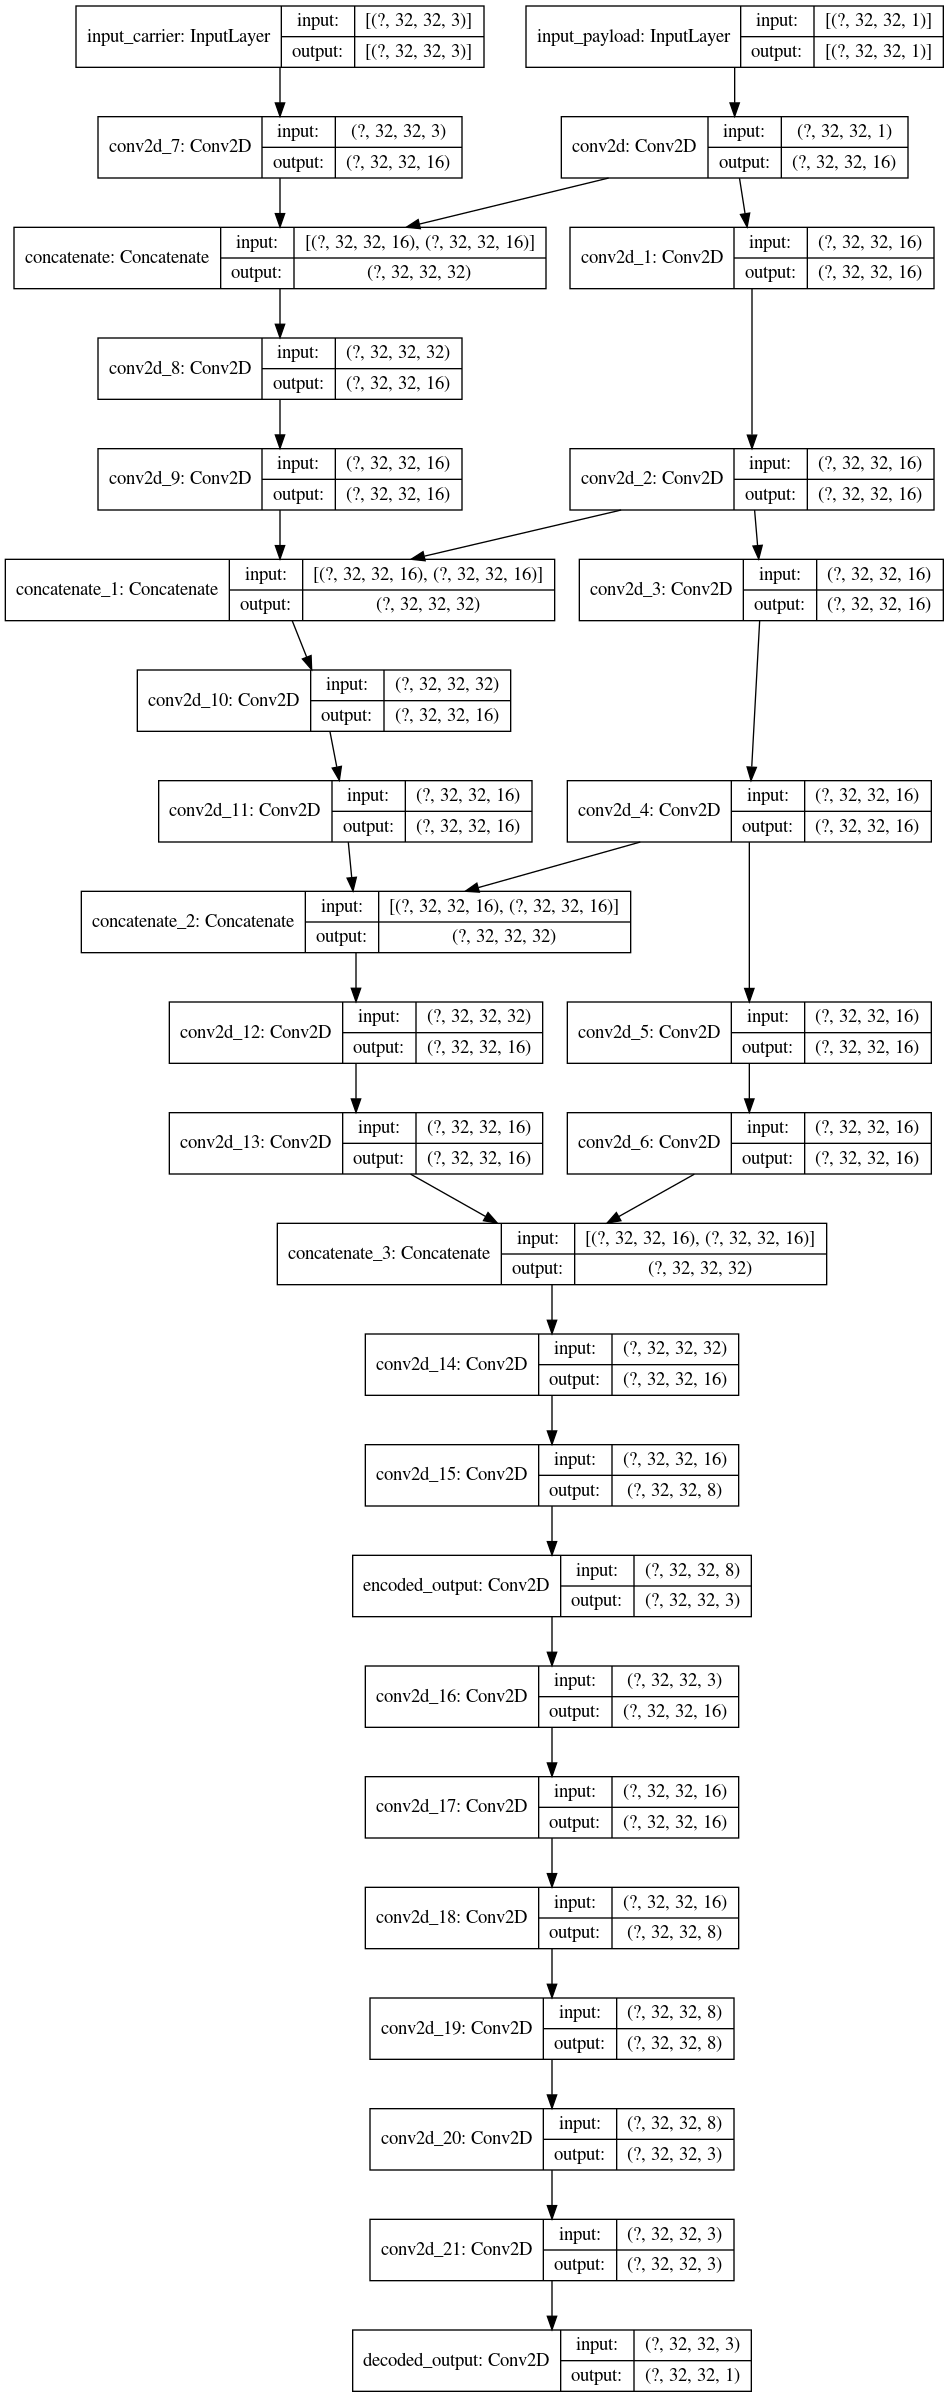

In [14]:
from tensorflow.keras.utils import plot_model
plot_model(steganography_model, show_shapes=True)

In [15]:
steganography_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_carrier (InputLayer)      [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
input_payload (InputLayer)      [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 32, 32, 16)   448         input_carrier[0][0]              
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   160         input_payload[0][0]              
______________________________________________________________________________________________

In [16]:
# Defining Loss Function


@tf.function
def loss_function(payload, host, encoder_output, decoder_output):

    loss = tf.math.reduce_mean(
        tf.math.squared_difference(payload, decoder_output) +
        tf.math.squared_difference(host, encoder_output))

    return loss

In [17]:
optimizer = tf.keras.optimizers.Adam(0.0001)

In [18]:
test_loss = tf.keras.metrics.Mean(name='test_loss')
train_loss = tf.keras.metrics.Mean(name='train_loss')


@tf.function
def train_step(payload, host):
    with tf.GradientTape() as tape:
        encoded_host, decoded_payload = steganography_model([host, payload])
        loss = loss_function(payload, host, encoded_host, decoded_payload)
        train_loss(loss)
    gradients = tape.gradient(loss, steganography_model.trainable_variables)
    optimizer.apply_gradients(
        zip(gradients, steganography_model.trainable_variables))

    train_host_psnr = tf.reduce_mean(tf.image.psnr(host, encoded_host, 1))
    train_payload_psnr = tf.reduce_mean(
        tf.image.psnr(payload, decoded_payload, 1))

    train_host_ssim = tf.reduce_mean(tf.image.ssim(host, encoded_host, 1))
    train_payload_ssim = tf.reduce_mean(
        tf.image.ssim(payload, decoded_payload, 1))

    return train_host_psnr, train_payload_psnr, train_host_ssim, train_payload_ssim


@tf.function
def test_step(payload, host):
    encoded_host, decoded_payload = steganography_model([host, payload])
    t_loss = loss_function(payload, host, encoded_host, decoded_payload)
    test_loss(t_loss)

    test_host_psnr = tf.reduce_mean(tf.image.psnr(host, encoded_host, 1))
    test_payload_psnr = tf.reduce_mean(
        tf.image.psnr(payload, decoded_payload, 1))

    test_host_ssim = tf.reduce_mean(tf.image.ssim(host, encoded_host, 1))
    test_payload_ssim = tf.reduce_mean(
        tf.image.ssim(payload, decoded_payload, 1))

    return test_host_psnr, test_payload_psnr, test_host_ssim, test_payload_ssim

In [ ]:
import time
EPOCHS = 250
SUMMARY_DIR = './summary'

for epoch in range(EPOCHS):
    start = time.time()

    # for when payload is rgb
    train_size = x.shape[0]
    test_size = x_test.shape[0]

    payload_train_idx = np.arange(train_size)
    np.random.shuffle(payload_train_idx)
    payload_train = x[payload_train_idx]
    if payload_image_shape[-1] == 1:
        # for when payload is grayscale
        payload_train = np.expand_dims(np.mean(payload_train, axis=-1),
                                       axis=-1)

    host_train_idx = np.arange(train_size)
    np.random.shuffle(host_train_idx)
    host_train = x[host_train_idx]

    
    payload_test_idx = np.arange(test_size)
    np.random.shuffle(payload_test_idx)
    payload_test = x_test[payload_test_idx]
    if payload_image_shape[-1] == 1:
        # for when payload is grayscale
        # for when payload is grayscale
        payload_test = np.expand_dims(np.mean(payload_test, axis=-1), axis=-1)

    host_test_idx = np.arange(test_size)
    np.random.shuffle(host_test_idx)
    host_test = x_test[host_test_idx]

    # Normalization function


    def deprecated_normalize(payload, host):
        payload = tf.image.per_image_standardization(payload)
        host = tf.image.per_image_standardization(host)
        return payload, host

    def normalize(payload, host):
        payload = tf.divide(
            tf.math.subtract(payload, tf.reduce_min(payload)),
            tf.math.subtract(tf.reduce_max(payload), tf.reduce_min(payload)))
        host = tf.divide(
            tf.math.subtract(host, tf.reduce_min(host)),
            tf.math.subtract(tf.reduce_max(host), tf.reduce_min(host)))
        return payload, host

    # Instantiate the Dataset class
    train_dataset = tf.data.Dataset.from_tensor_slices(
        (payload_train, host_train))
    # Adding shuffle, normalization and batching operations to the dataset object
    train_dataset = train_dataset.map(normalize).shuffle(5000).batch(
        256, drop_remainder=True)

    # Instantiate the test Dataset class
    test_dataset = tf.data.Dataset.from_tensor_slices(
        (payload_test, host_test))
    test_dataset = (test_dataset.map(normalize).batch(
        128, drop_remainder=True)).shuffle(500)

    for payload, host in train_dataset:
        train_host_psnr, train_payload_psnr, train_host_ssim, train_payload_ssim = train_step(
            payload, host)

    for payload, host in test_dataset:
        test_host_psnr, test_payload_psnr, test_host_ssim, test_payload_ssim = test_step(
            payload, host)

    elapsed = time.time() - start
    print('elapsed: %f' % elapsed)

    template = 'Epoch {}, Train Loss: {}, Test Loss: {}, TrainH PSNR: {}, TrainP PSNR: {}, TestH PSNR: {}, TestP PSNR: {}, TrainH SSIM: {}, TrainP SSIM: {}, TestH SSIM: {}, TestP SSIM: {}'
    print(
        template.format(epoch + 1, train_loss.result(), test_loss.result(),
                        train_host_psnr, train_payload_psnr, test_host_psnr,
                        test_payload_psnr, train_host_ssim, train_payload_ssim,
                        test_host_ssim, test_payload_ssim))

    # Reset the metrics for the next epoch
    test_loss.reset_states()

print('Training Finished.')

In [20]:
payload_test = x_test[np.random.choice(np.arange(x_test.shape[0]),
                                       size=x_test.shape[0])]
if payload_image_shape[-1] == 1:
    # for when payload is grayscale
    # for when payload is grayscale
    payload_test = np.expand_dims(np.mean(payload_test, axis=-1), axis=-1)

host_test = x_test[np.random.choice(np.arange(x_test.shape[0]),
                                    size=x_test.shape[0])]
# Instantiate the test Dataset class
test_dataset = tf.data.Dataset.from_tensor_slices((payload_test, host_test))
test_dataset = (test_dataset.map(normalize).batch(
    256, drop_remainder=True)).shuffle(500)

for payload, host in test_dataset:
    test_host_psnr, test_payload_psnr, test_host_ssim, test_payload_ssim = test_step(
        payload, host)

print("Test Loss: ", test_loss.result(), "PSNR-H: ", test_host_psnr,
      "PSNR-P: ", test_payload_psnr)

Test Loss:  tf.Tensor(0.0045731, shape=(), dtype=float32) PSNR-H:  tf.Tensor(25.947412, shape=(), dtype=float32) PSNR-P:  tf.Tensor(29.795643, shape=(), dtype=float32)


In [21]:
def test_normalize(payload, host):
    normalized_payload = tf.divide(
        tf.math.subtract(payload, tf.reduce_min(payload)),
        tf.math.subtract(tf.reduce_max(payload), tf.reduce_min(payload)))
    normalized_host = tf.divide(
        tf.math.subtract(host, tf.reduce_min(host)),
        tf.math.subtract(tf.reduce_max(host), tf.reduce_min(host)))
    return normalized_payload, normalized_host, payload, host

## Inference

In [22]:
def normed_to_image(normed_image, min_, max_):
    return (normed_image * (max_ - min_)) + min_

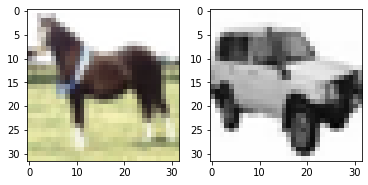

In [36]:
example_ids = np.arange(len(host_test))[:100]
example_id = np.random.choice(example_ids)

# showing host
fig, axs = plt.subplots(ncols=2)

host_example = host_test.astype(int)[example_id]
payload_example = payload_test.astype(int)[example_id]

payload_example = np.concatenate(
    (payload_example, payload_example, payload_example), axis=-1)
axs[0].imshow(host_example)
axs[1].imshow(payload_example, cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


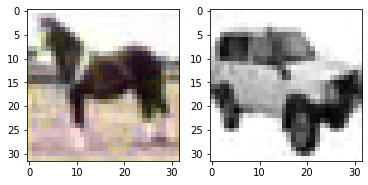

In [37]:
# showing host
fig, axs = plt.subplots(ncols=2)

inference_dataset = tf.data.Dataset.from_tensor_slices(
    (payload_test[example_ids],
     host_test[example_ids])).map(test_normalize).batch(len(example_ids))
for norm_payload, norm_host, payload, host in inference_dataset:
    encoded_host, decoded_payload = steganography_model(
        [norm_host, norm_payload])
    host_outputs = encoded_host.numpy()
    payload_output = decoded_payload.numpy()

    host_outputs = normed_to_image(host_outputs, np.min(host), np.max(host))
    payload_output = normed_to_image(payload_output, np.min(payload),
                                     np.max(payload))

host_output = host_outputs.astype(int)[example_id]
payload_output = payload_output.astype(int)[example_id]

payload_output = np.concatenate(
    (payload_output, payload_output, payload_output), axis=-1)

axs[0].imshow(host_output)
axs[1].imshow(payload_output)